# Predicting BigQuery & AutoML

This notebook illustrates:
<ol>
<li> Machine Learning using BigQuery
<li> Jupyter Magic for BigQuery in Cloud Datalab
</ol>

Please see [this notebook](1_explore.ipynb) for more context on this problem and how the features were chosen.

In [ ]:
# change these to try this notebook out
PROJECT = 'demoairenault'
REGION = 'europe-west1'

In [ ]:
import os
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [ ]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Exploring the Data

In [ ]:
%%bigquery df
WITH DATA AS
(SELECT 
       MOD(JOBID,4) AS HASH_JOBID, 
FROM
  `demoairenault.challenge.training_data`)

SELECT * FROM DATA WHERE HASH_JOBID >0

In [ ]:
df.head()

,HASH_JOBID,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK_NTNU,MBS,RUNEND,TIMESTEP,NBNODES,NBELEM1D,NBELEM2D,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME,ELAPSEDTIME
0,3,2018.0.1,POLE,1,YES,NO,NO,NO,110.01,0.0005,4507694,14570,4037272,1570802,HPC3,8.0,288,446.0,15600
1,3,2018.0.1,POLE,1,YES,NO,NO,NO,110.01,0.0005,4507694,14570,4037272,1570802,HPC3,8.0,288,446.0,14600
2,3,2018.0.1,POLE,1,YES,NO,NO,NO,110.01,0.0005,4507694,14570,4037272,1570802,HPC3,8.0,288,446.0,15600
3,3,2018.0.1,POLE,1,YES,NO,NO,NO,110.01,0.0005,4507694,14570,4037272,1570802,HPC3,8.0,288,446.0,14600
4,2,2018.0.1,PEDESTRIAN,1,NO,NO,NO,NO,40.68,0.0005,1647532,3760,1673587,103822,HPC3,1.0,36,74.7,4510


## Train Model

With the relevant columns chosen to accomplish predictions, it is then possible to create (train) the model in BigQuery. First, a dataset will be needed store the model. (if this throws an error in Datalab, simply create the dataset from the BigQuery console).

In [ ]:
%%bash
bq --location=EU mk -d demo

With the demo dataset ready, it is possible to create a linear regression model to train the model.

This will take approximately **4 minutes** to run and will show **Done** when complete.

In [ ]:
%%bigquery model
CREATE or REPLACE MODEL demo.automl_model
OPTIONS(model_type='AUTOML_REGRESSOR',
               input_label_cols=['ELAPSEDTIME'],
               budget_hours=1.0)
AS 
SELECT 
       VERSION, PERFORMANCE, PRECISION, MPLINK, NTNU, MPLINK_NTNU,
       MBS, RUNEND, TIMESTEP, NBNODES, NBELEM1D, NBELEM2D,
       NBELEM3D, CLUSTER, NBSERVERS, NBCORE, DATACHECK_TIME,
       ELAPSEDTIME
FROM
  `demoairenault.challenge.training_data`
WHERE MOD(JOBID,4)<3 



Executing query with job ID: 0b6d9638-debc-4af3-b7b5-9dc8a2118dd7
Query executing: 439.91s

## Training Statistics

During the model training (and after the training), it is possible to see the model's training evaluation statistics.

For each training run, a table named `<model_name>_eval` is created. This table has basic performance statistics for each iteration.

While the new model is training, review the training statistics in the BigQuery UI to see the below model training: https://bigquery.cloud.google.com/

Since these statistics are updated after each iteration of model training, you will see different values for each refresh while the model is training.

The training details may also be viewed after the training completes from this notebook.

In [ ]:
%%bigquery
SELECT * FROM ML.TRAINING_INFO(MODEL demo.automl_model);

Some of these columns are obvious although what do the non-specific ML columns mean (specific to BQML)?

**training_run** - Will be zero for a newly created model. If the model is re-trained using warm_start, this will increment for each re-training.

**iteration** - Number of the associated `training_run`, starting with zero for the first iteration.

**duration_ms** - Indicates how long the iteration took (in ms).

Note: You can also see these stats by refreshing the BigQuery UI window, finding the `<model_name>` table, selecting on it, and then the Training Stats sub-header.

Let's plot the training and evaluation loss to see if the model has an overfit.

As you can see, the training loss and evaluation loss are essentially identical. We do not seem to be overfitting.

## Model Evaluation with BQML using the Model

With a trained model, it is now possible to make a prediction on the values. The only difference from the second query above is the reference to the model. The data has been limited (`LIMIT 100`) to reduce amount of data returned.

When the `ml.predict` function is leveraged, output prediction column name for the model is `predicted_<label_column_name>`.

In [ ]:
%%bigquery
SELECT
  *
FROM
  ml.EVALUATE(MODEL demo.automl,
(SELECT 
    *
FROM
  `demoairenault.challenge.training_data`
WHERE MOD(JOBID,4) =3))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,3668.74664,4.031653e+07,0.082881,2004.242676,0.892879,0.894356


In [ ]:
%%bigquery data
SELECT
  *
FROM
  ml.PREDICT(MODEL demo.automl_model,
(SELECT 
    *
FROM
  `demoairenault.challenge.training_data`
WHERE MOD(JOBID,4) =0))
    LIMIT 1000

<AxesSubplot:xlabel='ELAPSEDTIME', ylabel='ELAPSEDTIME'>

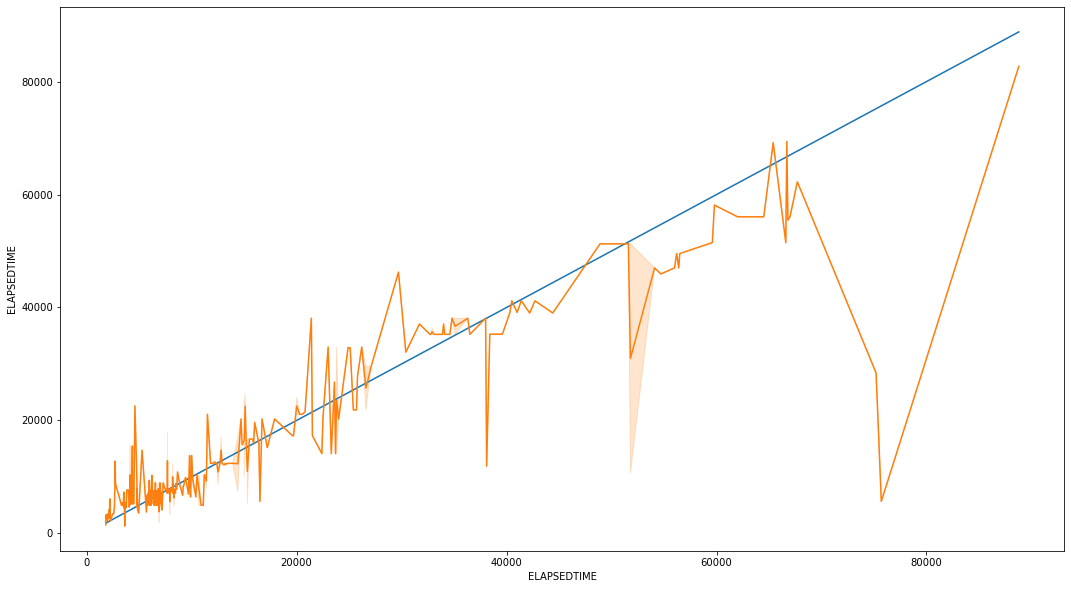

In [ ]:
from matplotlib import pyplot
import seaborn as sns
fig, ax = pyplot.subplots()
fig.set_size_inches(18, 10)
sns.lineplot(x="ELAPSEDTIME", y="ELAPSEDTIME", data=data)
sns.lineplot(x="ELAPSEDTIME", y="predicted_ELAPSEDTIME", data=data)